In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

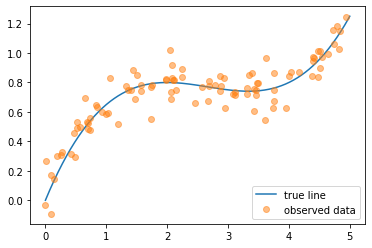

In [68]:
# synthetic polynomial data
xvals = np.linspace(0,5,1000)
coefs = np.array([1, -0.4, 0.05])
yvals = coefs[0]*xvals + coefs[1]*xvals**2 + coefs[2]*xvals**3

np.random.seed(1)
N = 100
x = np.random.uniform(0, 5, size=N)
y = coefs[0]*x + coefs[1]*x**2 + coefs[2]*x**3 + np.random.normal(0, 0.1, size=N)


plt.plot(xvals, yvals, label="true line")
plt.plot(x, y, "o", label="observed data", alpha=0.5)
plt.legend(loc="lower right");

In [195]:
hyperparams = np.array([5,5,5])

In [105]:
def pred(c):
    """
    Input array of coeffecients; output array of predicted y-hat values
    """
    return c[0]*x + c[1]*x**2 + c[2]*x**3

In [70]:
def test_pred_correct_value():
    # unit test
    pass

In [71]:
# replace log likelihood with log joint probability

In [72]:
def log_likelihood(c):
    """
    Input a value for the coeffecients and return the (negative) squared-error loss. This
    is the same as the log-likelihood for a Normal distribution up to a constant
    factor (that will drop out in our acceptance ratios)
    """
    return -np.sum((pred(c)-y)**2) 

### Metropolis-Hastings proposal testing

#### Refresher: what does MH do?

Start with some value for our parameters $\theta_{0}$. Each iteration $t$,

1. Sample a **candidate value** $\theta^{'}$ near $\theta_{t}$
2. Compute $f(\theta)$ for both $\theta_{t}$ and $\theta^{'}$, where $f$ is some function $f(\theta) \propto P(\theta|y)$
3. Compute the **acceptance ratio** $\alpha = f(\theta^{'})/f(\theta_{t})$
4. Sample a random number on the unit interval, $u \sim Uniform(0,1)$
5. Decide whether to accept or reject. 

  * If $u \le \alpha$: **accept**; $\theta_{t+1}=\theta^{'}$
  * If $u \gt \alpha$: **reject**; $\theta_{t+1}=\theta_{t}$



#### The plan

We're drawing samples from a function

$P(\theta|y) \propto P(y|\theta)P(\theta)$

So for the MH accept/reject decision we need to compute $P(y|\theta)P(\theta)$ for each proposed value of our regression parameters $\theta$. Since the MH acceptance depends on a ratio,

$\alpha = \frac{P(y|\theta^{'})P(\theta^{'})}{P(y|\theta)P(\theta)}$

we can ignore any proportionality constants. It's also generally useful, when computing with probabilities, to use logarithms so that we don't get rounding errors for values close to zero. So what we'll actually compute (remembering that $\log[a/b] = \log[a]-\log[b]$) is

$\log[\alpha] = \log[P(y|\theta^{'})P(\theta^{'})] - \log[P(y|\theta)P(\theta)]$

#### Prior

The prior is a normal distribution,

$P(\theta) = P(\theta_{1})P(\theta_{2})P(\theta_{3}) \propto \prod_{j=1}^{3}exp\left(-\frac{1}{2} \left(\frac{\theta_{j}}{\sigma_{j}}\right)^{2} \right)$

where each $\sigma_{j}$ is the prior hyperparameter for the $j$th parameter. By making any of the hyperparameters smaller, we can encode prior knowledge that that parameter should be close to zero. Our unnormalized log probability is

$\log[P(\theta)] = -\sum_{j=1}^{3}\frac{1}{2} \left(\frac{\theta_{j}}{\sigma_{j}}\right)^{2} $


#### Likelihood

The likelihood is also a normal distribution (of $y$ this time). If we define $\hat{y}_{i}(\theta)$ to be the prediction for observation $i$ and parameters $\theta$, then (since we've set the variance to one)

$P(x|\theta) = \prod_{i=1}^{N}P(y_{i}|\theta) \propto \prod_{i}exp\left(-\frac{1}{2} (y_{i} - \hat{y}_{i}(\theta))^{2} \right)$

So the unnormallized log likelihood is

$\log[P(x|\theta)] = -\sum_{i=1}^{N} \frac{1}{2} (y_{i} - \hat{y}_{i}(\theta))^{2} $

#### Putting it all together

Every MH update, you'll decide to accept or reject based on whether $\log[u]$ is greater or less than

$-\sum_{i=1}^{N} \frac{1}{2} (y_{i} - \hat{y}_{i}(\theta))^{2} -\sum_{j=1}^{3}\frac{1}{2} \left(\frac{\theta_{j}}{\sigma_{j}}\right)^{2}$

#### Your mission

* write a function `pred()` that inputs a value of $\theta$ and returns predictions $\hat{y}_{i}(\theta)$ for all $i$
* write a function `log_prob()` that inputs a value of $\theta$ and returns the unnormalized log probability. It will need to call `pred()` to compute the likelihood
* write a function `metropolis_hastings_update()` that inputs a value of $\theta$ and a jump distance, and returns three things:
  * the next value of $\theta$
  * the corresponding log-probability (which we'll use to tune our burn-in)
  * a Boolean that's `True` if this was an acceptance or `False` if it was a rejection (which we'll use to tune the jump distance)
  
A couple things you may need:

* `np.random.normal(0,jump_distance,3)` to generate a Gaussian hop for a 3D array
* `np.random.uniform(0,1)` to generate a random number on the unit interval

In [ ]:
def pred(c):
    """
    Input array of coeffecients; output array of predicted y-hat values
    """
    return c[0]*x + c[1]*x**2 + c[2]*x**3

In [ ]:
def test_pred_correct_value():
    # unit test
    pass

In [208]:
def log_prob(c):
    """
    Input a value for the coeffecients and return the (negative) squared-error loss. This
    is the same as the log-likelihood for a Normal distribution up to a constant
    factor (that will drop out in our acceptance ratios)
    """
    return -0.5*np.sum((pred(c)-y)**2) - 0.5*np.sum((c/hyperparams)**2)

In [209]:
def test_log_likelihood():
    pass

In [210]:
def metropolis_hastings_update(c, jump_distance):
    """
    Perform an update step for MH:
        -input old parameters
        -sample new ones
        -compute an acceptance ratio comparing the new to old
        -decide whether to accept or reject and return the new value
    """
    c_prime = c + np.random.normal(0, jump_distance, 3)
    old_prob = log_prob(c)
    new_prob = log_prob(c_prime)
    log_acceptance_ratio = new_prob - old_prob
    
    u = np.random.uniform(0,1)
    # accept
    if np.log(u) <= log_acceptance_ratio:
        return c_prime, new_prob, True
    # reject
    else:
        return c, old_prob, False

In [211]:
def test_metropolis_hastings_update():
    pass

In [221]:
c = np.array([0,0,0])
jd = 8e-3
liks = []
cs= []
accepts = 0
N = 50000

for i in range(N):
    c, l, a = metropolis_hastings_update(c, jd)
    liks.append(l)
    cs.append(c)
    accepts += int(a)
    
print("acceptance fraction: %s"%(accepts/N))

acceptance fraction: 0.2202


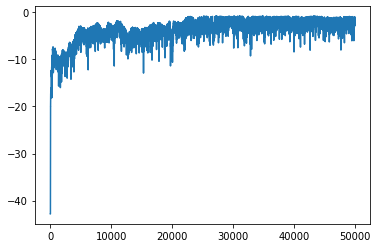

In [222]:
plt.plot(liks);

In [223]:
cs = np.stack(cs)
cs.shape

(50000, 3)

In [224]:
cs.mean(axis=0)

array([ 0.75372907, -0.25384666,  0.02969736])

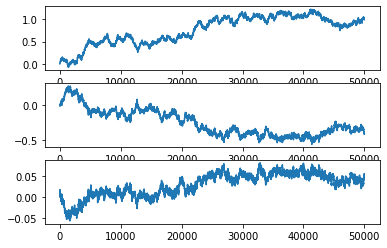

In [225]:
for i in range(3):
    plt.subplot(3,1,i+1)
    plt.plot(cs[:,i]);

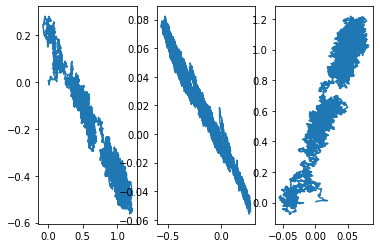

In [226]:
plt.subplot(131)
plt.plot(cs[:,0], cs[:,1]);

plt.subplot(132)
plt.plot(cs[:,1], cs[:,2]);

plt.subplot(133)
plt.plot(cs[:,2], cs[:,0]);

## burnin and thinning

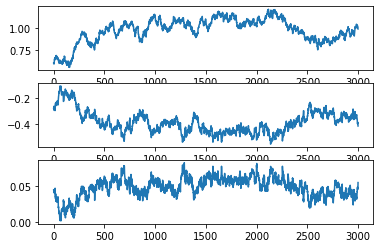

In [227]:
burnin = 20000
thin = 10
for i in range(3):
    plt.subplot(3,1,i+1)
    plt.plot(cs[burnin::thin,i]);

In [228]:
i = -1
y_post = cs[i,0]*xvals + cs[i,1]*xvals**2 + cs[i,2]*xvals**3

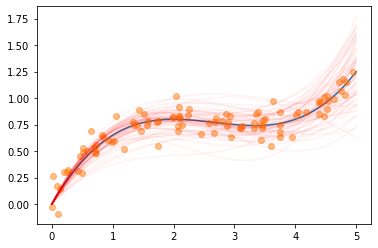

In [229]:
plt.plot(xvals, yvals, label="true line")
plt.plot(x, y, "o", label="observed data", alpha=0.5)

for i in range(20000, 50000, 500):
    y_post = cs[i,0]*xvals + cs[i,1]*xvals**2 + cs[i,2]*xvals**3
    plt.plot(xvals, y_post, "r", alpha=0.05)